<a href="https://colab.research.google.com/github/yardsale8/probability_simulations_in_R/blob/main/2_6_plotting_estimated_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)
library(devtools)
install_github('yardsale8/purrrfect', force = TRUE)
library(purrrfect)


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpo7M3IH/remotes3246447a0227/yardsale8-purrrfect-d91fae7/DESCRIPTION’ ... OK
* preparing ‘purrrfect’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘purrrfect_1.0.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Introduction to Parametric Simulations

This chapter we have been studying various discrete parametric distributions.  Sometimes we wish to explore the properties of such a distribution over a set of parameters, and in this case, we can use the `tidyverse` and `purrr` toolset to capture the results.

## Outline

1. Setting up the parameter space using `tribble`.
2. Unnesting the parameters and adding trials.
3. Mapping over the parameters using `pmap`
4. Composing operations to save memory on large simulations.
5. Parametric sampling.

## First Motivating Problem - One Variable Parameter

<font color="aqua">**Our Task.**.   </font> Suppose we wish to explore the effects of the sample size on the mean and variance of a binomial random variable when $p=0.5$.  

<font color="aqua">**The Problem.** </font> Our current approach would require a separate simulation/pipe for each sample size.

<font color="aqua">**The Solution.**</font> Store the sample sizes in our experimental notebook and use them as mapping inputs.

### Three Approachs

1. Store the trials in a list column, then `map` transformations/aggregations.
2. Compose all actions from **2.** into a single `map`
3. Stack the trials into a long table, transform, and then group and aggregate. <font size="1">(covered in an upcoming notebook on plotting simulation results)</font>.

## Performing a Parametric Simulation using a List Column

In this variation of the simulation, we will
1. Store all the trials for each parameter (or combination of parameters) in a single row.
2. Use `map` or `pmap` to process those trials.

### Defining the parameter space using a `tribble`

1. Define all the names on the first row preceeded by `~`
2. Define the respective collections on the second row, respectively.

In [ ]:
tribble(~n,
        c(5,10,15))

n
<list>
"5, 10, 15"


### The "shape" of a parametric simulation using a list column.

1. Set up the parameter space using a `tribble`.
2. Unnest the parameter(s) of interest.
3. Use `map` or `pmap` to generate a list column of trials.
4. Use `map` or `pmap` to transform/summarize.
5. Drop the outcome column.

In [ ]:
# Unnested parameters
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 )

n
<dbl>
5
10
15


In [ ]:
# Use map to generate trials
p <- 0.5
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, p)),
           )
 )

n,.outcome
<dbl>,<list>
5,"3, 2, 3, 2, 2, 3, 2, 2, 3, 3"
10,"6, 4, 5, 4, 2, 6, 5, 7, 5, 5"
15,"4, 7, 8, 9, 7, 10, 8, 9, 6, 4"


In [ ]:
# Transform/summarize
p <- 0.5
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, p)),
            approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p
           )
 )

n,.outcome,approx.mu,exact.mu
<dbl>,<list>,<dbl>,<dbl>
5,"1, 4, 3, 1, 4, 4, 2, 2, 2, 1",2.4,2.5
10,"4, 7, 4, 5, 6, 5, 5, 2, 5, 4",4.7,5.0
15,"3, 6, 7, 6, 5, 6, 7, 6, 5, 12",6.3,7.5


In [ ]:
# Drop outcomes
p <- 0.5
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)),
            approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p
           )
 %>% select(-.outcome)
 )

n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.5,2.5
10,5.4,5.0
15,7.1,7.5


In [ ]:
# Good estimate by bumping the num.trials
p <- 0.5
num.trials <- 100000
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)),
            approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p
           )
 %>% select(-.outcome)
 )

n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.50560,2.5
10,5.01159,5.0
15,7.49294,7.5


### The Advantage to using a list column of outcomes

The advantage of storing the trials in a list column is
1. All the information is self-contained and apparent, and
2. Makes it easier to verify your code and debug.

In [ ]:
# Transform/summarize
p <- 0.5
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)), # Easy to
            approx.mu = map_dbl(.outcome, mean),                # verify
            exact.mu = n*p                                      # correctness
           )
 )

n,.outcome,approx.mu,exact.mu
<dbl>,<list>,<dbl>,<dbl>
5,"2, 2, 5, 2, 4, 2, 3, 1, 3, 4",2.8,2.5
10,"8, 3, 4, 1, 5, 5, 4, 5, 6, 5",4.6,5.0
15,"9, 10, 6, 8, 7, 7, 7, 8, 11, 5",7.8,7.5


### Two Problems with using a list column of outcomes

Two problems with storing outcomes in a list column are

#### 1. Displaying more than a few trials is a mess

In [ ]:
# Slightly Better estimates
num.trials <- 100
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)), # Yuck! So long!
            approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p
           )
 )

n,.outcome,approx.mu,exact.mu
<dbl>,<list>,<dbl>,<dbl>
5,"2, 4, 2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 3, 3, 4, 3, 3, 3, 0, 3, 3, 2, 2, 4, 2, 3, 3, 3, 3, 3, 3, 1, 4, 3, 1, 0, 2, 3, 4, 1, 3, 2, 2, 3, 2, 1, 1, 4, 2, 2, 2, 1, 3, 1, 2, 2, 3, 3, 3, 1, 4, 2, 3, 2, 4, 2, 2, 2, 3, 3, 3, 3, 2, 4, 3, 0, 3, 3, 3, 3, 2, 1, 1, 2, 2, 2, 4, 4, 4, 1, 5, 3, 2, 4, 1, 1, 2, 1, 3, 3",2.46,2.5
10,"5, 2, 6, 6, 6, 6, 4, 3, 4, 7, 6, 5, 5, 5, 7, 2, 7, 5, 6, 7, 7, 6, 5, 4, 7, 7, 4, 6, 6, 4, 4, 8, 4, 5, 5, 5, 1, 6, 5, 2, 2, 3, 3, 6, 4, 7, 5, 4, 5, 3, 4, 4, 6, 5, 4, 4, 7, 3, 4, 2, 5, 6, 5, 6, 5, 3, 5, 6, 6, 7, 6, 5, 6, 8, 4, 6, 4, 4, 5, 5, 5, 4, 7, 5, 8, 4, 5, 6, 7, 6, 5, 7, 4, 5, 8, 5, 6, 7, 3, 6",5.10,5.0
15,"7, 9, 7, 8, 8, 6, 9, 4, 10, 6, 8, 5, 5, 8, 5, 6, 7, 9, 8, 7, 9, 8, 5, 9, 7, 9, 7, 8, 8, 8, 7, 9, 6, 6, 9, 10, 4, 5, 7, 7, 7, 4, 8, 8, 9, 5, 5, 4, 7, 11, 9, 6, 9, 4, 9, 10, 5, 7, 9, 7, 5, 5, 7, 9, 7, 6, 11, 10, 11, 8, 4, 8, 7, 6, 5, 4, 11, 5, 7, 5, 9, 5, 7, 8, 7, 7, 7, 7, 8, 9, 6, 5, 9, 6, 8, 6, 9, 10, 9, 7",7.23,7.5


#### 2. We are storing a *lot* of data during most intermediate steps.

In [ ]:
# Drop outcomes
num.trials <- 100000 # Start adding zeros and see what happens
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)), # <== Lots of data/memory used
            approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p
           )
 %>% select(-.outcome)
 )

n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.50311,2.5
10,4.99170,5.0
15,7.49737,7.5


### The Solution

The solution is to

1. Prototype the code using a separate list column of outcomes,
2. Verify the correctness of your code, then
2. Compose the steps into a single function

## The "shape" of a composed parametric simulation

1. Set up the parameter space using a `tribble`.
2. Unnest the parameter(s) of interest.
3. Use one `map` or `pmap` to perform the entire process, usually by piping each intermediate result into the next function.

In [ ]:
# First prototype WITH the outcome column
p <- 0.5
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)), # Easy to
            approx.mu = map_dbl(.outcome, mean),                # verify
            exact.mu = n*p                                      # correctness
           )
 )

n,.outcome,approx.mu,exact.mu
<dbl>,<list>,<dbl>,<dbl>
5,"2, 1, 3, 2, 2, 2, 3, 3, 3, 3",2.4,2.5
10,"6, 6, 7, 5, 4, 8, 3, 6, 5, 7",5.7,5.0
15,"8, 9, 7, 9, 6, 10, 9, 7, 8, 6",7.9,7.5


In [ ]:
# Second ... Compose!
num.trials <- 100
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n)
 %>% mutate(approx.mu = map_dbl(n, \(n) (rbinom(num.trials, n, 0.5)
                                        %>% mean)),
            exact.mu = n*p
           )
)

n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.67,2.5
10,4.95,5.0
15,7.62,7.5


### When can you compose?

When each step is saved, then immediately used on the next step.

#### Tracking the data

Here the raw trials are saved as `.outcome`, which is then used as input on the next mutate.

In [ ]:
num.trials <- 10
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n) # ────────┐
 %>% mutate(.outcome = map(n, \(n) rbinom(num.trials, n, 0.5)),
            # │  └─────────────────────┘
            # └────────────────────┐
            approx.mu = map_dbl(.outcome, mean),
            #   │                  └──────┘ │
            #   └───────────────────────────┘
            exact.mu = n*p
           )
 %>% select(-.outcome)
 )

n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.2,2.5
10,5.9,5.0
15,7.5,7.5


#### Tracking the data

Instead of saving the intermediate result (i.e., the raw output) we can simply pipe it into the next action.

In [ ]:
# Compose!
num.trials <- 100
(tribble(~n,
         c(5,10,15))
 %>% unnest_longer(n) # ─────────────┐
 %>% mutate(approx.mu = map_dbl(n, \(n) (rbinom(num.trials, n, 0.5)
          #   │                              │
                                        %>% mean)),
          #   └──────────────────────────────┘
            exact.mu = n*p)
           )


n,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>
5,2.34,2.5
10,5.15,5.0
15,7.74,7.5


### <font color="red"> Exercise 2.5.1 </font>

Suppose that we want to compare the cut off for the top 5% of a binomial data with $n = 100$ and $p\in\{0.25, 0.5, 0.75\}

**Tasks.**
1. Prototype the process by storing the raw outcomes in a list column, then processing with additional `map`s,
2. Verify the correctness of your code, and
2. Compose all the intermediate steps to eliminate the need to store the raw outcomes.

In [ ]:
# Your code here.

## Parametric Simulations with more than one parameter

A similar process can be used to simulate a scenario where two or more parameters vary across the experiment.  Depending on the scenario, we will
1. **Two parameters.** Use either `map2` or `pmap` to generate the raw outcomes.
2. **Three+ parameters.** Use `pmap` to generate the raw outcomes.

### Example 2 - Investigate the mean part 2

Now suppose we want to investigate the mean of the binomial distribution for all combinations of $n\in\{5,10,15\}$ and $p\in\{0.25, 0.5, 0.74\}$.  

#### Step 1.  Define the parameter space

In [ ]:
# Define the parameter space
tribble(~n,         ~p,
        c(5,10,15), c(0.25, 0.5, 0.75))

n,p
<list>,<list>
"5, 10, 15","0.25, 0.50, 0.75"


#### Step 2. Unnest both parameters

In [ ]:
# Unnest both parameters
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 )

n,p
<dbl>,<dbl>
5,0.25
5,0.50
5,0.75
10,0.25
10,0.50
10,0.75
15,0.25
15,0.50
15,0.75


#### Step 3.  Generate outcomes with `map2`

In [ ]:
# Version 1 - Use map2 to generate the data
num.trials <- 10
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% mutate(.outcome = map2(n, p, \(n, p) rbinom(num.trials, n, p)))
 )

n,p,.outcome
<dbl>,<dbl>,<list>
5,0.25,"1, 4, 0, 1, 1, 0, 0, 1, 2, 0"
5,0.50,"2, 4, 2, 1, 3, 1, 4, 3, 1, 5"
5,0.75,"5, 2, 5, 1, 3, 3, 5, 2, 3, 3"
10,0.25,"1, 4, 2, 6, 4, 4, 4, 2, 2, 1"
10,0.50,"7, 5, 2, 5, 3, 3, 3, 4, 4, 6"
10,0.75,"8, 9, 10, 8, 8, 7, 6, 9, 7, 8"
15,0.25,"3, 5, 3, 4, 4, 3, 4, 7, 3, 4"
15,0.50,"7, 9, 6, 8, 9, 6, 6, 6, 5, 8"
15,0.75,"11, 12, 9, 11, 13, 11, 10, 8, 11, 14"


#### Step 3. Generate outcomes with `pmap`.

In [ ]:
# Version 2 - Use pmap to generate the data
num.trials <- 10
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% mutate(.outcome = pmap(list(size = n, prob = p), rbinom, n = num.trials))
 )

n,p,.outcome
<dbl>,<dbl>,<list>
5,0.25,"1, 3, 2, 1, 1, 1, 1, 1, 0, 0"
5,0.50,"2, 1, 4, 1, 4, 2, 3, 1, 3, 4"
5,0.75,"2, 5, 4, 3, 4, 4, 4, 4, 4, 4"
10,0.25,"2, 1, 2, 3, 2, 2, 3, 2, 3, 2"
10,0.50,"5, 4, 5, 5, 5, 7, 4, 3, 5, 4"
10,0.75,"5, 7, 7, 7, 10, 8, 9, 8, 5, 8"
15,0.25,"2, 5, 3, 4, 2, 5, 1, 2, 2, 3"
15,0.50,"7, 9, 7, 6, 7, 7, 7, 8, 7, 7"
15,0.75,"12, 10, 11, 11, 11, 13, 12, 13, 12, 12"


#### Step 4. Process and summarize.

In [ ]:
um.trials <- 10
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% mutate(.outcome = map2(n, p, \(n, p) rbinom(num.trials, n, p)))
 %>% mutate(approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p)
 )

n,p,.outcome,approx.mu,exact.mu
<dbl>,<dbl>,<list>,<dbl>,<dbl>
5,0.25,"3, 2, 1, 0, 1, 1, 1, 1, 2, 2",1.4,1.25
5,0.50,"3, 4, 3, 1, 2, 0, 2, 2, 2, 1",2.0,2.50
5,0.75,"4, 2, 3, 4, 5, 4, 4, 5, 4, 5",4.0,3.75
10,0.25,"2, 2, 3, 1, 6, 3, 1, 3, 3, 4",2.8,2.50
10,0.50,"6, 6, 3, 6, 4, 2, 6, 7, 3, 8",5.1,5.00
10,0.75,"8, 5, 7, 7, 8, 8, 7, 6, 8, 8",7.2,7.50
15,0.25,"4, 6, 3, 4, 5, 6, 2, 3, 4, 2",3.9,3.75
15,0.50,"6, 3, 10, 8, 12, 6, 10, 7, 10, 4",7.6,7.50
15,0.75,"9, 12, 11, 8, 11, 9, 14, 11, 10, 13",10.8,11.25


#### Step 5. Drop outcomes and bump the number of trials.

In [ ]:
num.trials <- 100000
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% mutate(.outcome = map2(n, p, \(n, p) rbinom(num.trials, n, p)))
 %>% mutate(approx.mu = map_dbl(.outcome, mean),
            exact.mu = n*p)
 %>% select(-.outcome)
 )

n,p,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>,<dbl>
5,0.25,1.25111,1.25
5,0.50,2.50296,2.50
5,0.75,3.74988,3.75
10,0.25,2.50033,2.50
10,0.50,4.99747,5.00
10,0.75,7.50632,7.50
15,0.25,3.74829,3.75
15,0.50,7.50677,7.50
15,0.75,11.25170,11.25


Step 5. Compose into one map.

In [ ]:
num.trials <- 100000
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
#  %>% mutate(.outcome = map2(n, p, \(n, p) rbinom(num.trials, n, p))
#  %>% mutate(approx.mu = map_dbl(.outcome, mean),
            # exact.mu = n*p)
 %>% mutate(approx.mu = (map2(n, p, \(n, p) rbinom(num.trials, n, p))
                        %>% map_dbl(mean)),
            exact.mu = n*p)
#  %>% select(-.outcome)
 )

n,p,approx.mu,exact.mu
<dbl>,<dbl>,<dbl>,<dbl>
5,0.25,1.24687,1.25
5,0.50,2.50387,2.50
5,0.75,3.75187,3.75
10,0.25,2.50188,2.50
10,0.50,4.99318,5.00
10,0.75,7.49624,7.50
15,0.25,3.75959,3.75
15,0.50,7.49850,7.50
15,0.75,11.25313,11.25


### <font color="red"> Exercise 2.5.2 </font>

Suppose that we want to compare the cut off for the top 5% of a binomial data with $n\in c\{25, 50, 100\}$ and $p\in\{0.25, 0.5, 0.75\}$

**Tasks.**
1. Prototype the process by storing the raw outcomes in a list column, then processing with additional `pmap`/`map2`s,
2. Verify the correctness of your code, and
2. Compose all the intermediate steps to eliminate the need to store the raw outcomes.

In [ ]:
# Your code here

## Stacked and Plotting Parametric Simulations

The final option, not covered above, is to stack the outcomes in a simple, atomic column.  This approach is used primarily when plotting the distributions for each parameter or combination of parameters and has the advantage to this approach is simplier mutates (rarely need to map), but at the cost of spreading the related trials across multiple rows--requiring an extra grouped aggregation at the end.

### The "shape" of a stacked parametric simulation.

1. Set up the parameter space using a `tribble`.
2. Unnest the parameter(s) of interest.
3. Add trials to convert the parameter space into an experimental notebook.
4. Use `map` or `pmap` to generate outcomes using the parameter column(s) as input.
5. Proceed as usual (estimate probabilities, expected values, etc.).

### Setting up the parameter space

The `tribble` functions can create the nested parameter space, with

1. The names of the column, starting with `~`, on the first line, and
2. Vectors or lists of parameters on the second line.

Note that you need to line up the names and parameter vectors, respectively (first with first, second with second, etc.). The output is a `tibble` with one row, containing a list column for each parameter.



In [ ]:
tribble(~n,
        seq(5,15,5))

n
<list>
"5, 10, 15"


### Unnesting the parameters.

Next, we need to spread the parameters over multiple rows, with one parameter per row.  This is accomplished using `unnest_longer`

In [ ]:
(tribble(~n,
        seq(5,15,5))
 %>% unnest_longer(n)
 )

n
<dbl>
5
10
15


### Adding trials

Next, we need to replicate each parameter over a number of trials, which is accomplished using `add_trials`

In [ ]:
num.trials <- 5
(tribble(~n,
        seq(5,15,5))
 %>% unnest_longer(n)
 %>% add_trials(num.trials)
 )

n,.trial
<dbl>,<dbl>
5,1
5,2
5,3
5,4
5,5
10,1
10,2
10,3
10,4


#### Generating outcomes with `map`

To use map, we need to

1. Map onto the parameter column, and
2. Write a function that takes this parameter as input.

As alway, select the version of `map` that results in an atomic column type.  In this case, we will use `map_int`, as `rbinom` generates intergers.

In [ ]:
num.trials <- 5
p <- 0.5
(tribble(~n,
        seq(5,15,5))
 %>% unnest_longer(n)
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 )

n,.trial,num.successes
<dbl>,<dbl>,<int>
5,1,3
5,2,4
5,3,1
5,4,1
5,5,5
10,1,2
10,2,6
10,3,5
10,4,5


### Bump trials and plot with `ggplot`

Finally, we can complete the task, which involves grouping and aggregating to get estimates of the long-run mean for each sample size.

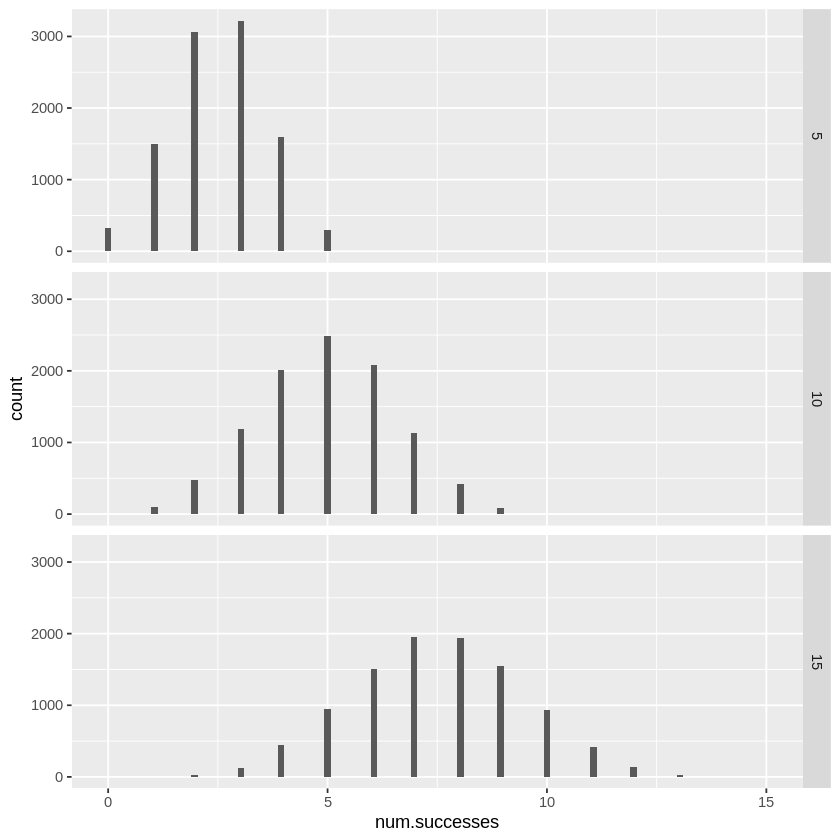

In [ ]:
# Test on small number of trials
num.trials <- 10000
p <- 0.5
(tribble(~n,
        seq(5,15,5))
 %>% unnest_longer(n)
 %>% add_trials(num.trials)
 %>% mutate(num.successes = map_int(n, \(n) rbinom(1, n, p)))
 %>% as.data.frame
 ) -> trials

ggplot(trials) +
   geom_histogram(aes(x = num.successes), bins = 100) +
   facet_grid(rows = vars(n))

### Example - Plotting a 2 parameter problem

Now suppose we want to compare distributions when changing both $n$ and $p$.

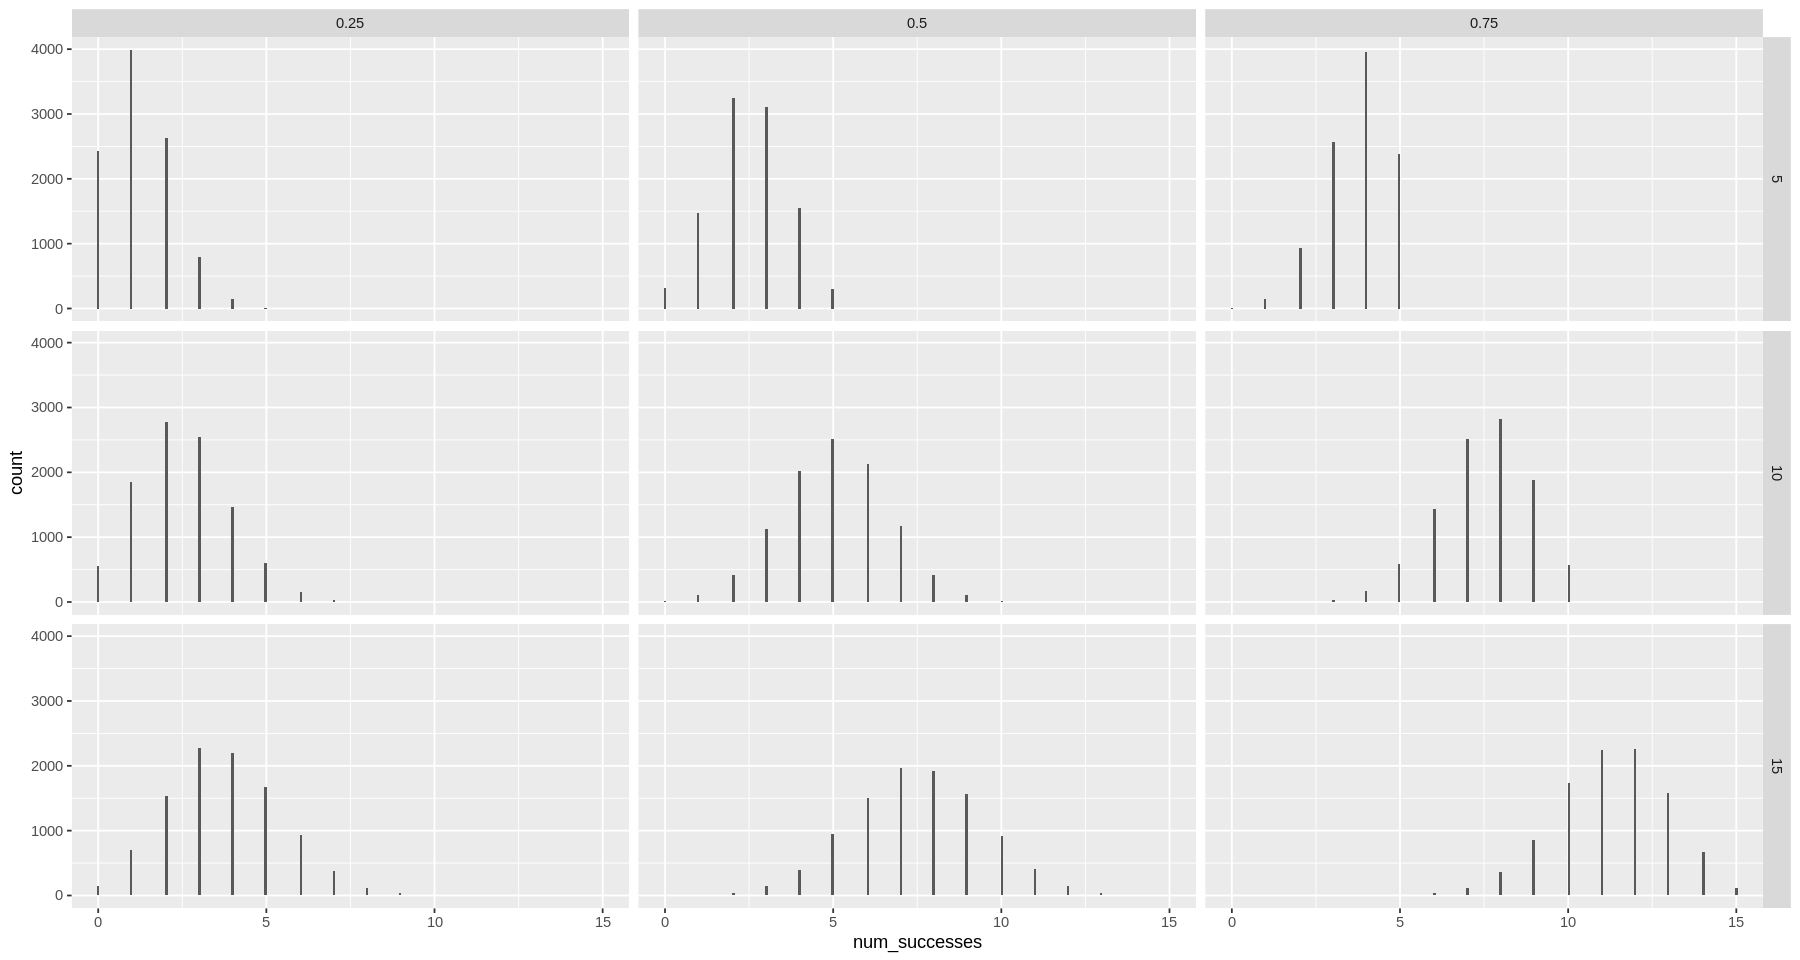

In [ ]:
num.trials <- 10000
(tribble(~n,         ~p,
         c(5,10,15), c(0.25, 0.5, 0.75))
 %>% unnest_longer(n)
 %>% unnest_longer(p)
 %>% add_trials(num.trials)
 %>% mutate(num_successes = map2_int(n, p, \(n, p) rbinom(1, n, p)))
 ) -> trials

# Make plots wider (Colab only)
options(repr.plot.width=15, repr.plot.height=8)

ggplot(trials) +
   geom_histogram(aes(x = num_successes), bins = 200) +
   facet_grid(rows = vars(n), cols = vars(p))

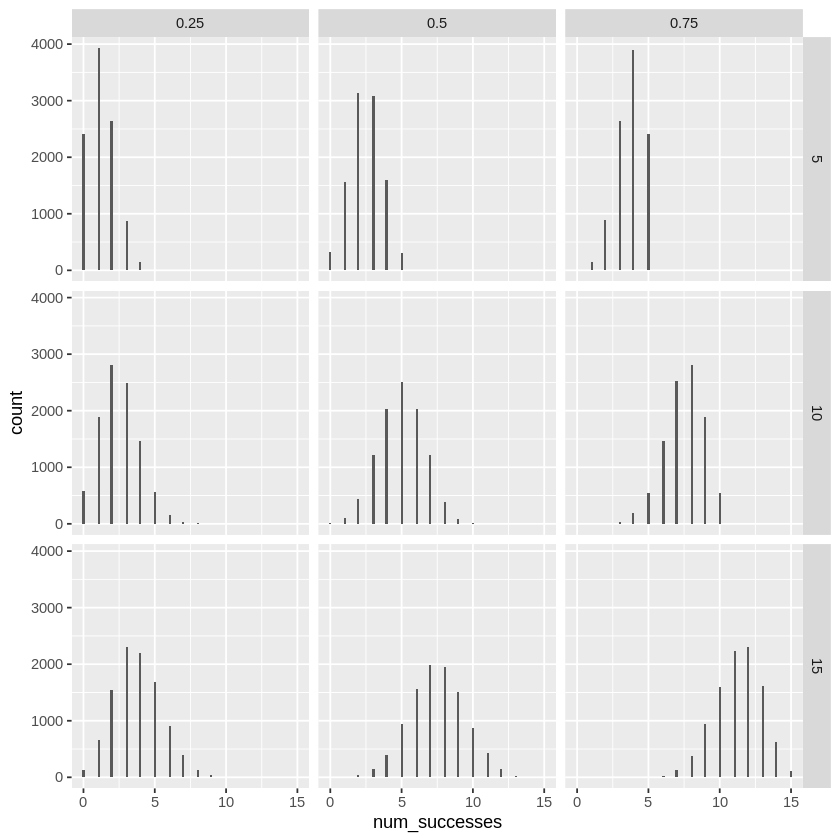